## Exploration_07 영화리뷰 텍스트 감성분석하기
### Step 1. 데이터 준비

In [467]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [468]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    word_to_index['<PAD>'] = 0
    word_to_index['<BOS>'] = 1
    word_to_index['<UNK>'] = 2    
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [469]:
# 비어있는 key 0, 1, 2를 각각의 값으로 채워준다.
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0] = '<PAD>'
index_to_word[1] = '<BOS>'
index_to_word[2] = '<UNK>'

In [470]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### data shape 및 함수 작동 확인

In [471]:
train_data.shape

(146183, 3)

In [472]:
test_data.shape

(49158, 3)

In [473]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [474]:
X_train[1]

[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]

In [475]:
get_decoded_sentence(X_train[4], index_to_word)

'익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다'

In [476]:
get_decoded_sentence(X_test[2], index_to_word)

'야 평점 . ... 나쁘 진 않 지만 10 점 짜리 더더욱 아니 잖아'

### Step 3. 모델구성을 위한 데이터 분석 및 가공
#### 적절한 최대 문장 길이 지정

In [477]:
# PAD 추가를 위해 max length를 정할 때 사용

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [478]:
# 문장 최대 길이 검색
sen_len = []
max_len = 0
for i in range(len(X_train)):
    sen_len.append(len(X_train[i]))
    if len(X_train[i]) > max_len:
        max_len = len(X_train[i])

print(f'문장길이 최대 재확인: {max_len}')

문장길이 최대 재확인: 116


#### 패딩 추가

In [479]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 'pre' 가 'post' 보다 계산상 좋다고함
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 'pre' 가 'post' 보다 계산상 좋다고함
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [480]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)  # 총 단어의 개수
word_vector_dim = 4    # 각 단어가 가지는 dimension

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(X_train)
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen) # 최대 문장길이
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  ...
  [-0.01356485  0.00429877 -0.02051493  0.02943074]
  [ 0.00593574 -0.02901868  0.03775239  0.01399142]
  [ 0.04682073 -0.02501825  0.00457961 -0.00614367]]

 [[ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  ...
  [ 0.04104718  0.00505706 -0.00472488  0.04498117]
  [ 0.03419307  0.03119436 -0.00881859 -0.02929885]
  [-0.03965174 -0.03420528  0.01091882  0.01970886]]

 [[ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  [ 0.0009033  -0.00227249  0.03501468  0.02782368]
  ...
  [ 0.01807387  0.04592204  0.01503642  0.02590367]
  [-0.03185922 -0.03901904 -0.03580869  0.02568949]
  [ 0.03674388  0.03488635  0.01478097 -0.01845074]]

 ...

 [[ 0.0009033  -0.00227

### Step 4. 모델 구성 및 validation set 구성
#### 각 train, test 데이터의 길이 확인 및 타입 확인

In [481]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

146182
146182
49157
49157


In [482]:
round(len(X_train)*0.3)

43855

In [483]:
# Validation 을 위한 데이터 분리 ( train : val = 8 .5: 1.5)

# validation set 15% 분리
x_val = X_train[:round(len(X_train)*0.15)]
y_val = y_train[:round(len(X_train)*0.15)]

# validation set을 제외한 나머지 대략 85%
partial_x_train = X_train[round(len(X_train)*0.15):]  
partial_y_train = y_train[round(len(X_train)*0.15):]

# 변수들 크기 확인
print(len(partial_x_train))
print(len(partial_y_train))
print(len(x_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

124255
124255
21927
21927
49157
49157


In [484]:
# 변수들 type 확인

print(type(x_val))
print(type(y_val))
print(type(X_train))
print(type(y_train))
print(type(partial_x_train))
print(type(partial_y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Step 5. 모델 학습 시작 (embedding) & Step 6. 시각화
#### RNN model 학습

In [485]:
# RNN

vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 8.
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_90 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [486]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
243/243 [==============================] - 4s 12ms/step - loss: 0.6039 - accuracy: 0.6810 - val_loss: 0.3639 - val_accuracy: 0.8468
Epoch 2/20
243/243 [==============================] - 2s 10ms/step - loss: 0.3449 - accuracy: 0.8561 - val_loss: 0.3455 - val_accuracy: 0.8500
Epoch 3/20
243/243 [==============================] - 2s 10ms/step - loss: 0.3169 - accuracy: 0.8696 - val_loss: 0.3470 - val_accuracy: 0.8507
Epoch 4/20
243/243 [==============================] - 2s 10ms/step - loss: 0.3005 - accuracy: 0.8761 - val_loss: 0.3458 - val_accuracy: 0.8506
Epoch 5/20
243/243 [==============================] - 2s 10ms/step - loss: 0.2954 - accuracy: 0.8787 - val_loss: 0.3453 - val_accuracy: 0.8492
Epoch 6/20
243/243 [==============================] - 2s 10ms/step - loss: 0.2851 - accuracy: 0.8831 - val_loss: 0.3491 - val_accuracy: 0.8504
Epoch 7/20
243/243 [==============================] - 2s 10ms/step - loss: 0.2731 - accuracy: 0.8893 - val_loss: 0.3494 - val_accuracy: 0.8532

In [487]:
# 결과확인
rnn_results = model.evaluate(X_test,  y_test, verbose=1)

print(rnn_results)

1537/1537 [==============================] - 6s 4ms/step - loss: 0.5053 - accuracy: 0.8376
[0.5052735805511475, 0.837561309337616]


#### RNN model 시각화
* 각 train, validation data에 대한 loss, accuracy의 변화를 그래프상의 실선과 점선으로 비교

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


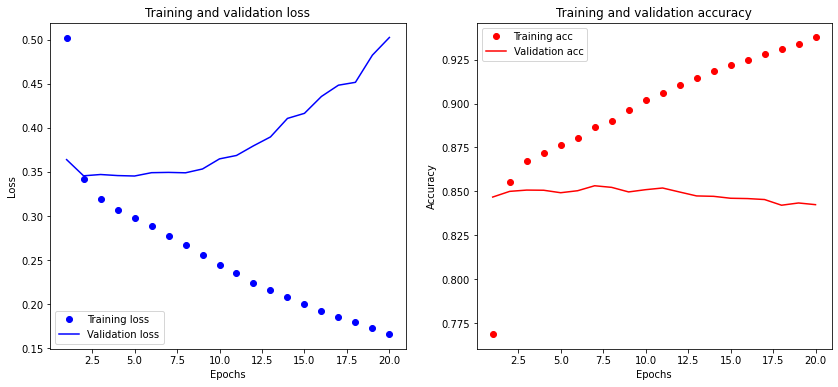

In [488]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'ro', label='Training acc', )
ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

* overfitting 이 과하게 발생하는 걸 볼 수 있다. 
* 따라서 어느정도 이를 방지 하기 위해 dropout()을 추가 해 주고 다시 실행 해 보았다.

In [489]:
# RNN + dropout

vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 8  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.LSTM(8))   # 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 8)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_92 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_37 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 9         
Total params: 80,625
Trainable params: 80,625
Non-trainable params: 0
_________________________________________________

In [490]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
243/243 [==============================] - 5s 12ms/step - loss: 0.6408 - accuracy: 0.6278 - val_loss: 0.3912 - val_accuracy: 0.8386
Epoch 2/20
243/243 [==============================] - 2s 10ms/step - loss: 0.4401 - accuracy: 0.7957 - val_loss: 0.3588 - val_accuracy: 0.8474
Epoch 3/20
243/243 [==============================] - 2s 10ms/step - loss: 0.4129 - accuracy: 0.8231 - val_loss: 0.3483 - val_accuracy: 0.8491
Epoch 4/20
243/243 [==============================] - 3s 10ms/step - loss: 0.3927 - accuracy: 0.8276 - val_loss: 0.3459 - val_accuracy: 0.8506
Epoch 5/20
243/243 [==============================] - 3s 11ms/step - loss: 0.3816 - accuracy: 0.8363 - val_loss: 0.3445 - val_accuracy: 0.8519
Epoch 6/20
243/243 [==============================] - 3s 11ms/step - loss: 0.3776 - accuracy: 0.8370 - val_loss: 0.3445 - val_accuracy: 0.8522
Epoch 7/20
243/243 [==============================] - 3s 11ms/step - loss: 0.3739 - accuracy: 0.8397 - val_loss: 0.3471 - val_accuracy: 0.8508

In [491]:
# 결과확인
rnn_results = model.evaluate(X_test,  y_test, verbose=1)

print(rnn_results)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3595 - accuracy: 0.8469
[0.35951656103134155, 0.8468783497810364]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


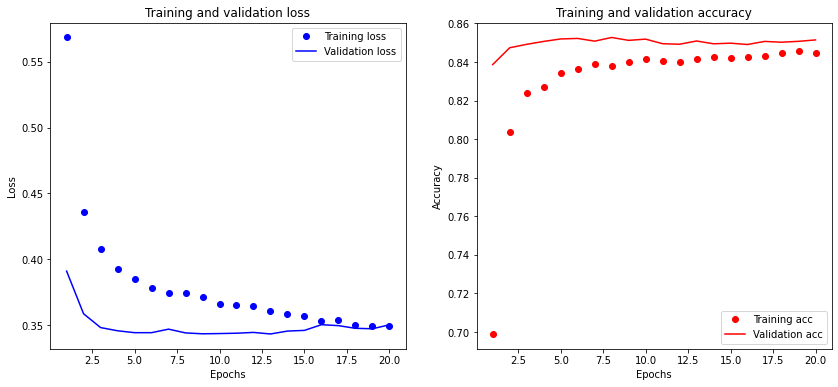

In [492]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'ro', label='Training acc', )
ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

* 그래프를 통해 overfitting 문제가 어느정도 해소된 것을 볼 수 있다.

#### CNN model 학습

In [493]:
# CNN + Dropout()
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
dropout_38 (Dropout)         (None, None, 8)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, None, 16)          912       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 16)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 8)               

In [494]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # RNN 에서 테스트한 epochs 결과에서 조금 더 변경 (epochs 20 -> 10)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
243/243 [==============================] - 2s 7ms/step - loss: 0.6699 - accuracy: 0.5573 - val_loss: 0.4231 - val_accuracy: 0.8289
Epoch 2/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4690 - accuracy: 0.7841 - val_loss: 0.3742 - val_accuracy: 0.8443
Epoch 3/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4401 - accuracy: 0.8002 - val_loss: 0.3592 - val_accuracy: 0.8472
Epoch 4/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4304 - accuracy: 0.8017 - val_loss: 0.3524 - val_accuracy: 0.8495
Epoch 5/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4193 - accuracy: 0.8101 - val_loss: 0.3526 - val_accuracy: 0.8488
Epoch 6/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4136 - accuracy: 0.8091 - val_loss: 0.3483 - val_accuracy: 0.8499
Epoch 7/10
243/243 [==============================] - 2s 7ms/step - loss: 0.4079 - accuracy: 0.8149 - val_loss: 0.3507 - val_accuracy: 0.8470
Epoch 

In [495]:
# 결과확인
cnn_results = model.evaluate(X_test,  y_test, verbose=1)

print(cnn_results)

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3488 - accuracy: 0.8459
[0.34876367449760437, 0.8459426164627075]


 #### CNN model 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


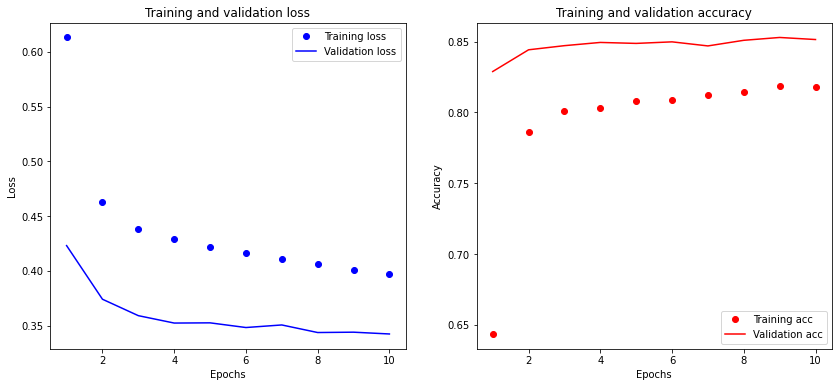

In [496]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'ro', label='Training acc', )
ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

* 다양한 테스트를 위해 epochs 를 20 -> 10 으로 변경하여 실행 해 보았다.
* 결과 점차적으로 수렴하고 있는것을 볼 수 있으며 epochs 20정도에서 RNN과 상당히 유사한 결과를 보일 것으로 예상 된다.

#### GMP model 학습

In [497]:
# GlobalMaxPooling1D
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_30 (Glo (None, 8)                 0         
_________________________________________________________________
dense_96 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_40 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________


In [498]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
243/243 [==============================] - 2s 5ms/step - loss: 0.6819 - accuracy: 0.5554 - val_loss: 0.5772 - val_accuracy: 0.7862
Epoch 2/10
243/243 [==============================] - 1s 4ms/step - loss: 0.5567 - accuracy: 0.7289 - val_loss: 0.4219 - val_accuracy: 0.8237
Epoch 3/10
243/243 [==============================] - 1s 4ms/step - loss: 0.4488 - accuracy: 0.8166 - val_loss: 0.3839 - val_accuracy: 0.8341
Epoch 4/10
243/243 [==============================] - 1s 4ms/step - loss: 0.4074 - accuracy: 0.8378 - val_loss: 0.3709 - val_accuracy: 0.8378
Epoch 5/10
243/243 [==============================] - 1s 4ms/step - loss: 0.3856 - accuracy: 0.8521 - val_loss: 0.3665 - val_accuracy: 0.8399
Epoch 6/10
243/243 [==============================] - 1s 4ms/step - loss: 0.3652 - accuracy: 0.8618 - val_loss: 0.3650 - val_accuracy: 0.8424
Epoch 7/10
243/243 [==============================] - 1s 4ms/step - loss: 0.3522 - accuracy: 0.8679 - val_loss: 0.3657 - val_accuracy: 0.8412
Epoch 

In [499]:
# 결과확인
gmp_results = model.evaluate(X_test,  y_test, verbose=1)

print(gmp_results)

1537/1537 [==============================] - 2s 1ms/step - loss: 0.3862 - accuracy: 0.8370
[0.38620635867118835, 0.8369510173797607]


#### GMP model 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


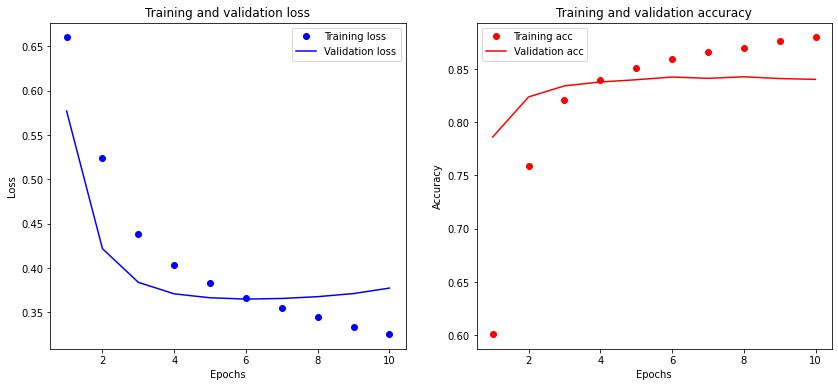

In [500]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'ro', label='Training acc', )
ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

* GMP의 경우에는 RNN, CNN과는 다르게 epochs 4~5 정도에서 그래프가 교차한 뒤에 다시 두 데이터간의 gap이 커지는 것을 볼 수 있다.
* 따라서 epochs를 5~6 정도로 수정 하거나 아니면 dropout 외의 regularization 방식을 사용해 볼 필요가 있어 보인다.

#### Test에 대한 3가지 모델에 대한 loss, accuracy 비교

In [501]:
results_df = pd.DataFrame(index=['RNN', 'CNN', 'GMP'], columns=['loss', 'accuracy'])
results_df.loc['RNN'] = rnn_results
results_df.loc['CNN'] = cnn_results
results_df.loc['GMP'] = gmp_results
results_df

,loss,accuracy
RNN,0.359517,0.846878
CNN,0.348764,0.845943
GMP,0.386206,0.836951


* 최종적으로 RNN과 CNN의 결과가 상당히 유사하게 나타난 것을 볼 수 있다.

### Step 7. Word2vec 활용

#### weights 설정

In [502]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 8)


#### 단어 와 해당 단어의 embedding 값을 파일로 저장

In [503]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_kr.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#### Embedding 불러오기

In [504]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['가족']
vector

array([-0.17780899, -0.10253113, -0.10615069,  0.14656729, -0.0883318 ,
       -0.1054718 , -0.11040214, -0.13656938], dtype=float32)

In [505]:
word_vectors.similar_by_word("가족")

[('아무튼', 0.9873428344726562),
 ('로코', 0.9825653433799744),
 ('문학', 0.9811904430389404),
 ('파도', 0.9810431599617004),
 ('독특', 0.9799637198448181),
 ('빛', 0.9784860610961914),
 ('집니다', 0.9777168035507202),
 ('적나라', 0.9761486649513245),
 ('이어지', 0.9720963835716248),
 ('다른가', 0.9701558351516724)]

* 결과를 확인해 보면 '가족'과는 전혀 관련이 없어보이는 단어들이 출력되는 것을 알 수 있다. 즉, 현재 데이터로는 제대로 된 학습이 되지 않았다고 보여진다.
* 비교를 위해 이번에는 pre-trained 된 모델을 가져와 다시 시도해 보았다.

#### Pre-trained model과 word2vec을 이용한 재 학습
**'자체학습'을 사용한 결과와 '사전학습'을 사용한 결과간의 차이 비교**

In [506]:
import gensim
#from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin' # ko.bin : pre-trained data
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [507]:
word2vec.similar_by_word("가족")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('친지', 0.6574771404266357),
 ('유족', 0.6132265329360962),
 ('부부', 0.5933582782745361),
 ('부모님', 0.5929263234138489),
 ('부모', 0.5834078192710876),
 ('식구', 0.5739837288856506),
 ('친족', 0.5737326741218567),
 ('노인', 0.5734318494796753),
 ('자녀', 0.5686265230178833),
 ('부유층', 0.5621210336685181)]

* 앞선 결과와는 다르게 이번에는 '가족'이라는 단어와 상당히 유사성이 있는 단어들이 출력 된 것을 볼 수 있다.
* 즉, 제대로 학습이 이뤄진 것이라 생각된다.

In [508]:
# dimension 설정을 위한 길이 확인
len(word2vec['가족'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


200

In [509]:
vocab_size = 10000   # 어휘 사전의 크기 설정
word_vector_dim = 200  # 위에서 확인한 dimension의 길이 입력

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### word2vec + CNN model 사용

In [511]:
# word2vec + CNN model
from tensorflow.keras.initializers import Constant

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200 # 위에서 확인한 dimension의  길이 입력

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # 드롭아웃 추가. 비율은 50%
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
dropout_41 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 16)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 8)               

* word2vec 과 CNN을 사용하여 학습을 진행한다

In [512]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=11

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/11
243/243 [==============================] - 8s 30ms/step - loss: 0.7023 - accuracy: 0.5062 - val_loss: 0.6805 - val_accuracy: 0.6266
Epoch 2/11
243/243 [==============================] - 7s 27ms/step - loss: 0.6310 - accuracy: 0.6236 - val_loss: 0.5056 - val_accuracy: 0.8029
Epoch 3/11
243/243 [==============================] - 6s 25ms/step - loss: 0.5057 - accuracy: 0.7271 - val_loss: 0.4526 - val_accuracy: 0.8313
Epoch 4/11
243/243 [==============================] - 6s 25ms/step - loss: 0.4640 - accuracy: 0.7498 - val_loss: 0.4215 - val_accuracy: 0.8421
Epoch 5/11
243/243 [==============================] - 6s 25ms/step - loss: 0.4467 - accuracy: 0.7604 - val_loss: 0.4106 - val_accuracy: 0.8467
Epoch 6/11
243/243 [==============================] - 6s 25ms/step - loss: 0.4335 - accuracy: 0.7747 - val_loss: 0.3875 - val_accuracy: 0.8481
Epoch 7/11
243/243 [==============================] - 6s 25ms/step - loss: 0.4047 - accuracy: 0.8160 - val_loss: 0.3744 - val_accuracy: 0.8504

In [513]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3561 - accuracy: 0.8515
[0.3560979664325714, 0.8514758944511414]


* epochs 수치를 11로 변경하여 실행하였을 때 목표 수치인 85%를 조금 넘기는 결과를 얻을 수 있었다.
* overfitting을 방지하기 위해 dropout()을 함께 사용하였다.

#### word2vec 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


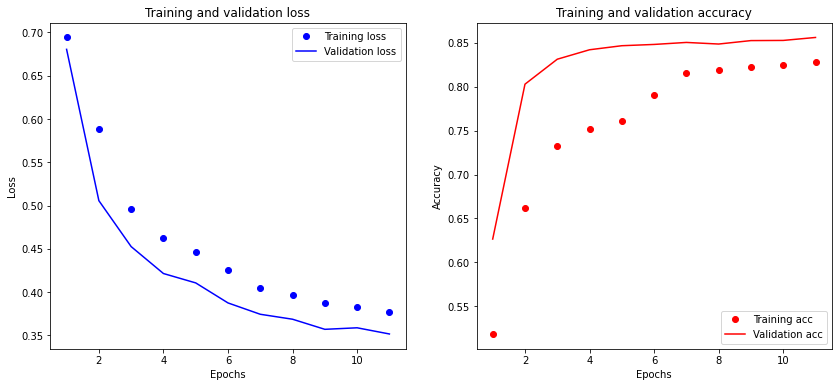

In [514]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'ro', label='Training acc', )
ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

* 그래프로 확인해본결과 validation data가 training data에 점차적으로 수렴해 가는 것을 볼 수 있다.
* epochs 를 좀 더 조절 한다면 15 정도까지가 적당 할 것이라 예상되며 그 이상은 다시 두 데이터간의 이격이 발생할 수 있어 추천하지 않는다.

### 회고
* '자체학습'을 시킨 결과와 '선행학습'이 된 결과를 가지고 유사 단어를 찾아 봤을 때 결과가 극과극으로 나오는 것이 신기했었다. '자체학습'에서도 어느정도는 유사한 결과가 나오지 않을까 했지만 전혀 그렇지 않았다.
* 따라서 이런 언어학습에 있어서는 역시나 방대한 양의 데이터를 이용해 학습을 시키는 것이 중요하다는 것을 다시한번 알 수 있게 되었다.
* RNN, CNN, GMP 모델간에는 그렇게 큰 차이를 느끼지 못했다. 특히 RNN과 CNN이 꽤나 유사하게 작동하는 것 처럼 보였다. 자연어 처리에서는 당연히 RNN을 대부분 쓰지 않을까 했지만 상황에 따라 CNN을 사용하는 것 또한 나쁘지 않아 보인다.
* 위의 테스트 결과를 보더라도 word2vec으로 embedding 한 결과에 CNN을 사용해도 목표치인 85%를 달성할 수 있었기에 무조건 RNN을 사용해야 하는 것은 아닌 것 같다.
* 그리고 overfitting을 좀 해결 해 보고자 dropout()을 추가 해 주었고 이 또한 목표치의 accuracy를 얻는데 도움이 되었다. 혹시 dropout()이 제대로 작동하지 않으면 그 다음으로 L2-regularization을 사용해 볼까 했었는데 다행이 목표치를 넘겼고, 다음에 이와 유사한 상황이 생기면 그 때는 dropout과 L2를 모두 사용하여 테스트 해볼 생각이다.